# **Imports and initialisation**

In [121]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import os

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Setting a random seed for reproducible result
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Here we import the 4 subdatasets from the data folder.

In [122]:
train_original = pd.read_csv('data/train_original.csv')
train_log = pd.read_csv('data/train_log.csv')
train_smokers = pd.read_csv('data/train_smokers.csv') 
train_smokers_squared = pd.read_csv('data/train_smokers_squared.csv') 


# **Original dataset**

Now that the preprocessing is done we can split the dataset into validation and train sets. The validation set represents 20% of each subdataset, it will be used to compare models.

In [123]:
X_train, X_validation, y_train, y_validation = train_test_split(train_original.drop("charges", axis=1), train_original[["charges"]], test_size=0.2, random_state=RANDOM_SEED) # create training and validation sets

First we train the model on the original dataset. We chose 3 different algorithms for each dataset, Linear regression, Random forest and XGboost. TThese models are effective on regression problems like the one we are facing.

## **Linear Regression**

We first test here the performance of a basic linear regression model.

In [124]:
lr = LinearRegression() # create linear regression object
lr.fit(X_train, y_train) # train model on training set
y_predictions = lr.predict(X_validation) # predict on validation set

We chose the RMSE metric because it is relevant for regression problems like this one. We also calculated the MAE but we will rely on the RMSE to compare the models.

In [125]:
rmse = root_mean_squared_error(y_validation, y_predictions) # calculate root mean squared error
mae = mean_absolute_error(y_validation, y_predictions) # calculate mean absolute error
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 6606.443367277778
MAE: 4482.695790334958


We visualize this first prediction.

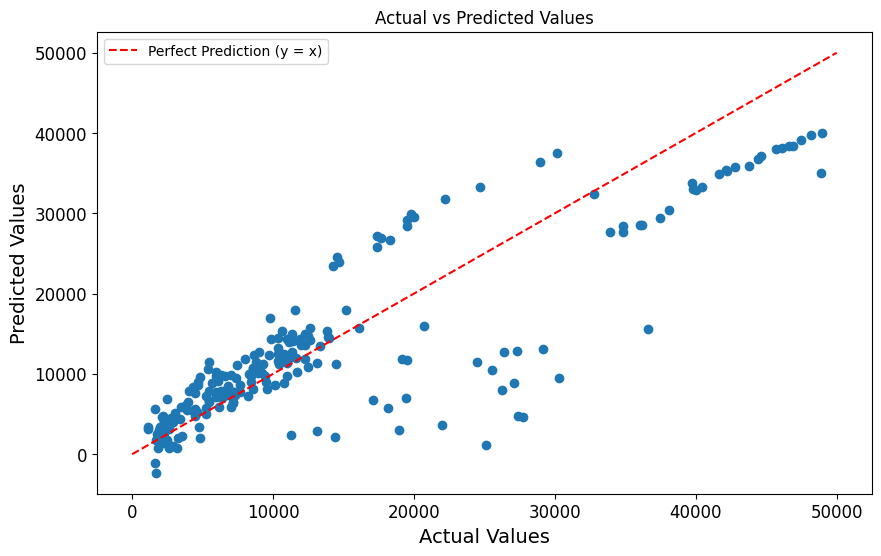

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 50000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

The line represents the perfect prediction where y = x, that is, when the prediction matches reality perfectly. Our goal is to have predictions as close as possible to this line.

## **Random Forest**

## **Training the model**


We first test here the performance of a basic random forest model. Then we will do some fine tuning to choose the right parameters using the GridSearch library.

In [127]:
rf = RandomForestRegressor(random_state=RANDOM_SEED) # create random forest regression object
rf.fit(X_train, y_train) # train model on training set

y_predictions = rf.predict(X_validation) 

In [128]:
rmse = root_mean_squared_error(y_validation, y_predictions) # calculate root mean squared error
mae = mean_absolute_error(y_validation, y_predictions) # calculate mean absolute error
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 5445.19050001959
MAE: 2830.5797444881173


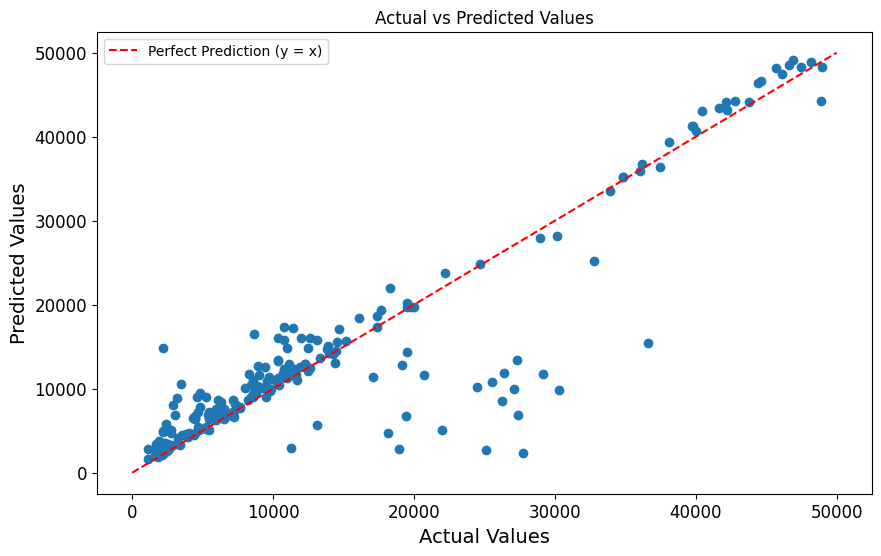

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 50000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

We use Gridsearch to search for the best parameters to use in training the model.

In [130]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
} # create parameter grid
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse') # create grid search object
grid_search.fit(X_train, y_train) # train grid search

print(grid_search.best_params_) 

{'max_depth': 10, 'n_estimators': 100}


In [131]:
best_rf = grid_search.best_estimator_ # get best model from grid search
y_predictions = best_rf.predict(X_validation) # predict on validation set

mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 73.63949385190855
MAE: 2816.6587467831678


## **XGBoost**

### **Training the data**

We do the same with the XGBoost model : first a simple model and then an optimized one.

In [132]:
xgb = XGBRegressor(random_state=RANDOM_SEED)
xgb.fit(X_train, y_train)

y_predictions = xgb.predict(X_validation)

In [133]:
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 76.95296007393137
MAE: 3316.258367453089


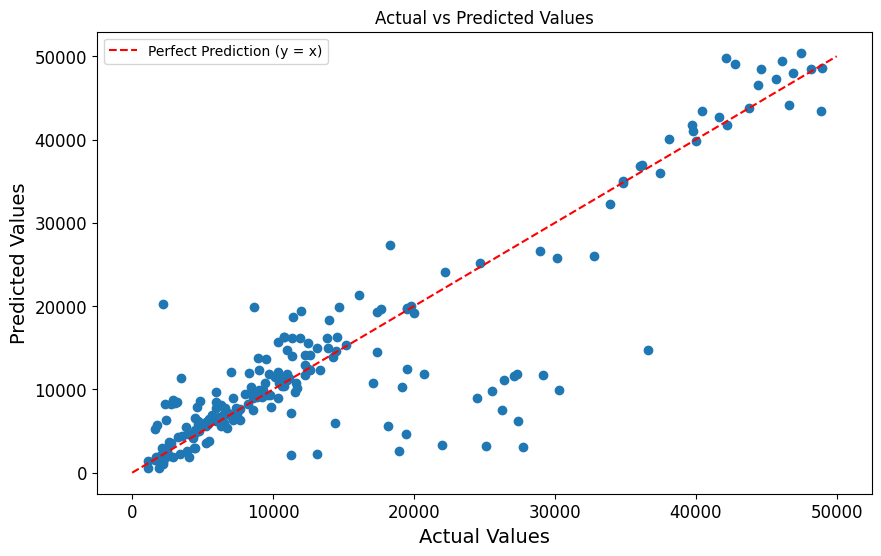

In [134]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 50000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [135]:
param_grid = {
    'max_depth': [None, 3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2, 0.3]
} 
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 3}


In [136]:
best_xgb = grid_search.best_estimator_
y_predictions = best_xgb.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 76.95296007393137
MAE: 2918.343730474226


From the results we can see that the Random Forest model performs the best if we choose RMSE as the main metric. RMSE needs to be the lowest. We create a dictionary to store the models and save the Random Forest model for the original dataset.

In [ ]:
os.makedirs('data/models', exist_ok=True) 
joblib.dump(best_rf, 'data/models/best_model_original.pkl') 

['data/models/best_model_original.pkl']

# **Log dataset**

Now, we follow the same protocol with our log dataset.

In [138]:
X_train, X_validation, y_train, y_validation = train_test_split(train_log.drop("charges", axis=1), train_log[["charges"]], test_size=0.2, random_state=RANDOM_SEED)

## **Linear Regression**

In [139]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_predictions = lr.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.7036701763199256
MAE: 0.296346796792894


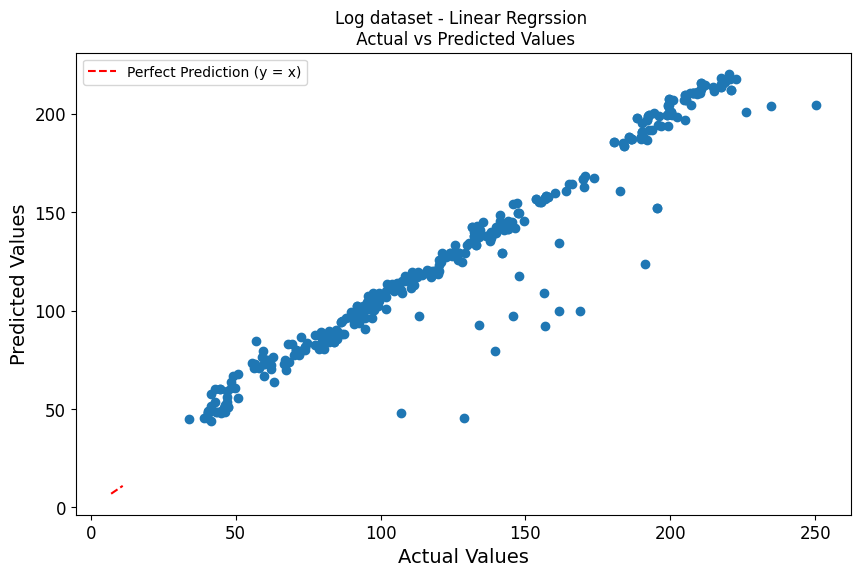

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(7, 11, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Log dataset - Linear Regression \n Actual vs Predicted Values')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## **Random Forest**

## **Training the model**


In [141]:
rf = RandomForestRegressor(random_state=RANDOM_SEED) # create random forest regression object
rf.fit(X_train, y_train) # train model on training set

y_predictions = rf.predict(X_validation) # predict on validation set
mse = root_mean_squared_error(y_validation, y_predictions) 
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.6790324639541211
MAE: 0.22598068013750802


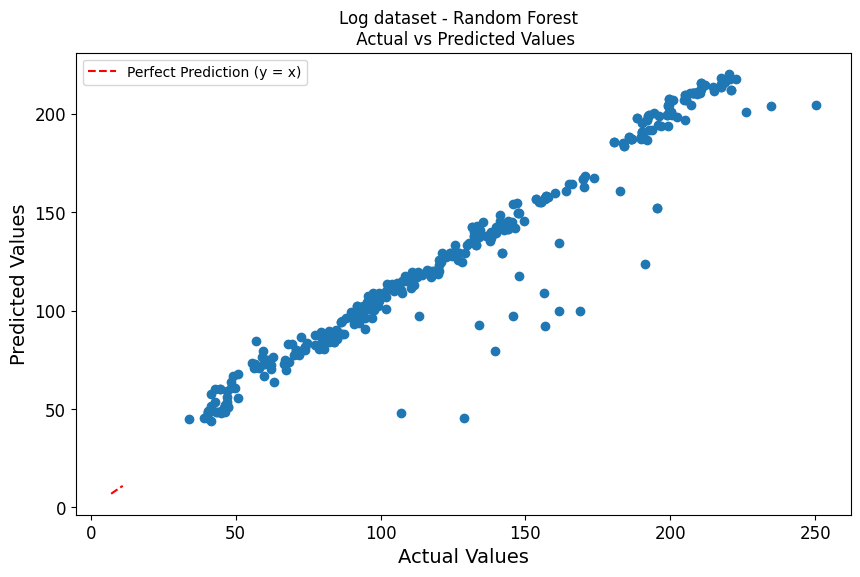

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(7, 11, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Log dataset - Random Forest  \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [143]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 300}


In [144]:
best_rf = grid_search.best_estimator_
y_predictions = best_rf.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.6770104624443275
MAE: 0.22830136333981702


## **XGBoost**

### **Training the data**

In [145]:
xgb = XGBRegressor(random_state=RANDOM_SEED)
xgb.fit(X_train, y_train)

y_predictions = xgb.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.7083634518849078
MAE: 0.256499415611508


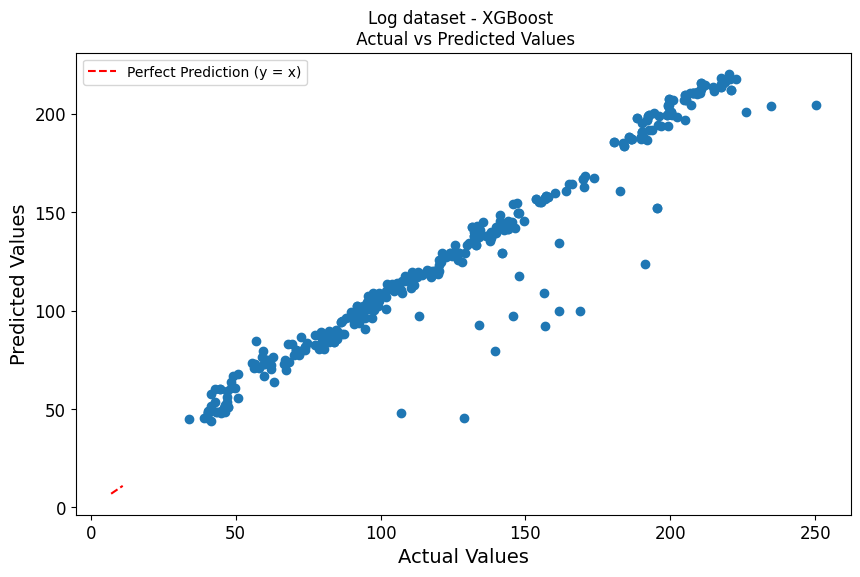

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(7, 11, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Log dataset - XGBoost \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [147]:
param_grid = {
    'max_depth': [None, 3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 3}


In [148]:
best_xgb = grid_search.best_estimator_
y_predictions = best_xgb.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.6659961426967715
MAE: 0.22941918181260762


From the results of the logarithmic values the XGBoost algorithm performs the best. We save this model to the directory.

In [149]:
joblib.dump(best_xgb, 'data/models/best_model_log.pkl')

['data/models/best_model_log.pkl']

# **Smokers dataset**

In [150]:
X_train, X_validation, y_train, y_validation = train_test_split(train_smokers.drop("charges", axis=1), train_smokers[["charges"]], test_size=0.2, random_state=RANDOM_SEED)

## **Linear Regression**

In [151]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_predictions = lr.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 80.23307854205446
MAE: 5342.469560396086


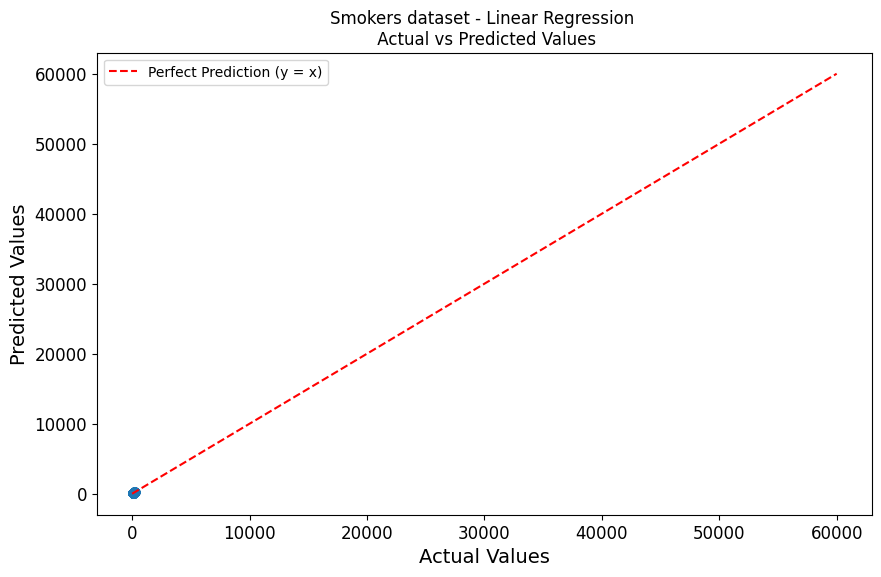

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 60000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers dataset - Linear Regression \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## **Random Forest**

## **Training the model**


In [153]:
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

y_predictions = rf.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 56.88218144671025
MAE: 1402.2663815275546


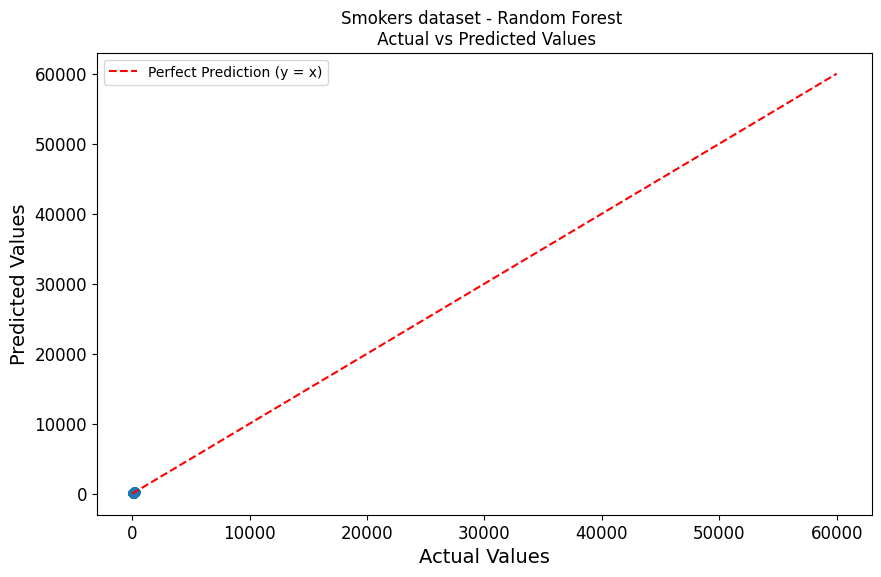

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 60000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers dataset - Random Forest \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [155]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 300}


In [156]:
best_rf = grid_search.best_estimator_
y_predictions = best_rf.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 56.40038864695668
MAE: 1432.1846156761146


## **XGBoost**

### **Training the data**

In [157]:
xgb = XGBRegressor(random_state=RANDOM_SEED)
xgb.fit(X_train, y_train)

y_predictions = xgb.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 59.285506255110164
MAE: 1529.223227280457


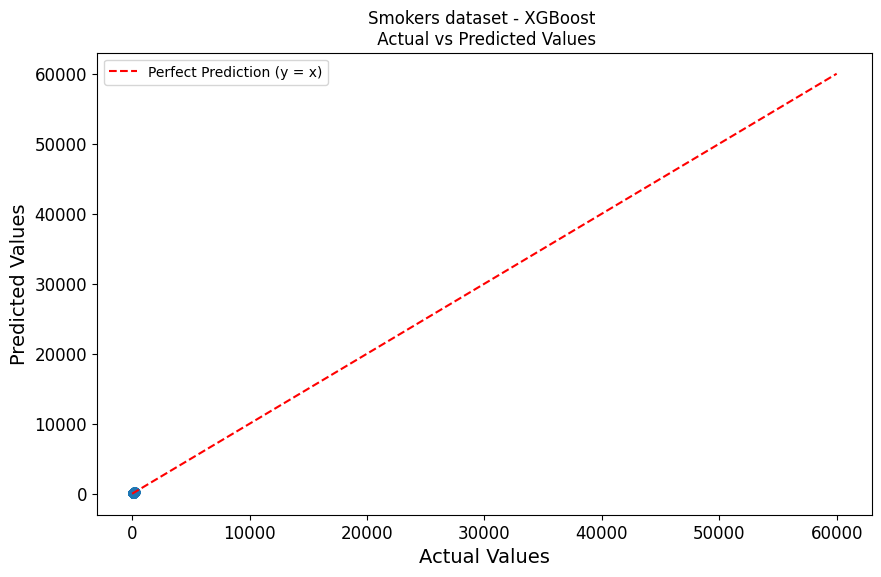

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 60000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers dataset - XGBoost \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [159]:
param_grid = {
    'max_depth': [None, 3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': None}


In [160]:
best_xgb = grid_search.best_estimator_
y_predictions = best_xgb.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 56.22686574076234
MAE: 1577.8048615674677


When comparing the results from the dataset with oversampled number of smokers the XGboost performs best. 

In [161]:
joblib.dump(best_xgb, 'data/models/best_model_smokers.pkl')

['data/models/best_model_smokers.pkl']

# **Smokers squared dataset**

In [162]:
X_train, X_validation, y_train, y_validation = train_test_split(train_smokers_squared.drop("charges", axis=1), train_smokers_squared[["charges"]], test_size=0.2, random_state=RANDOM_SEED)

## **Linear Regression**

In [163]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_predictions = lr.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 4.596558216691127
MAE: 17.230679654276283


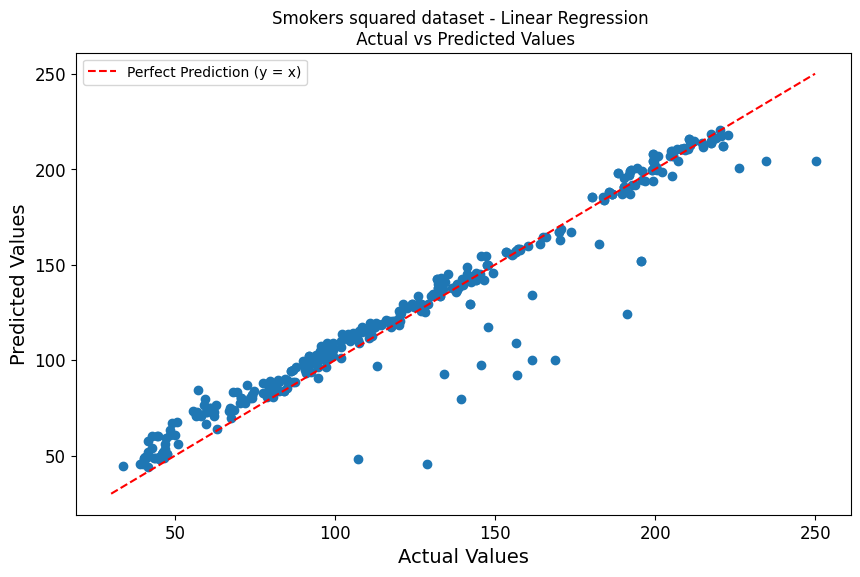

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(30, 250, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers squared dataset - Linear Regression \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## **Random Forest**

## **Training the model**


In [165]:
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

y_predictions = rf.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 3.8057657952451507
MAE: 6.23691625144478


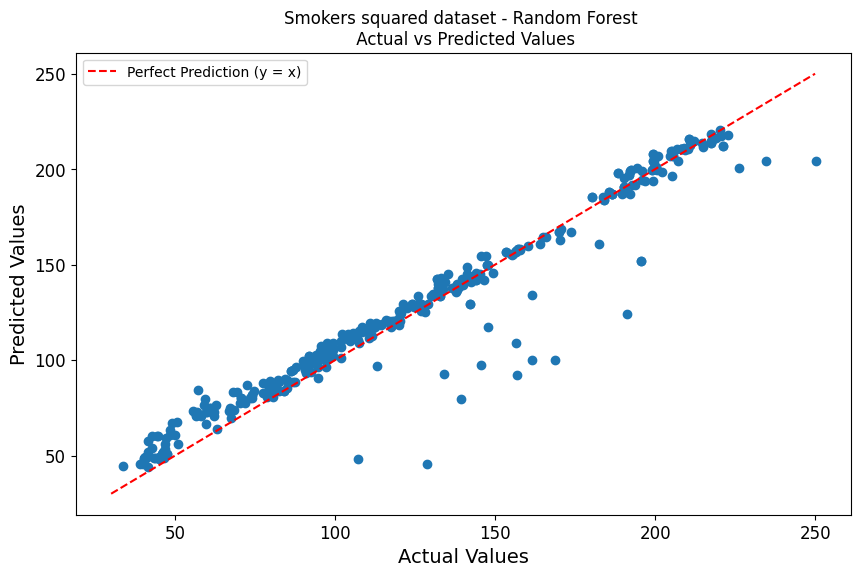

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(30, 250, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers squared dataset - Random Forest \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [167]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 300}


In [168]:
best_rf = grid_search.best_estimator_
y_predictions = best_rf.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 3.7604476186511615
MAE: 6.207081838450652


## **XGBoost**

### **Training the data**

In [169]:
xgb = XGBRegressor(random_state=RANDOM_SEED)
xgb.fit(X_train, y_train)

y_predictions = xgb.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 4.015328906739714
MAE: 7.170436677789045


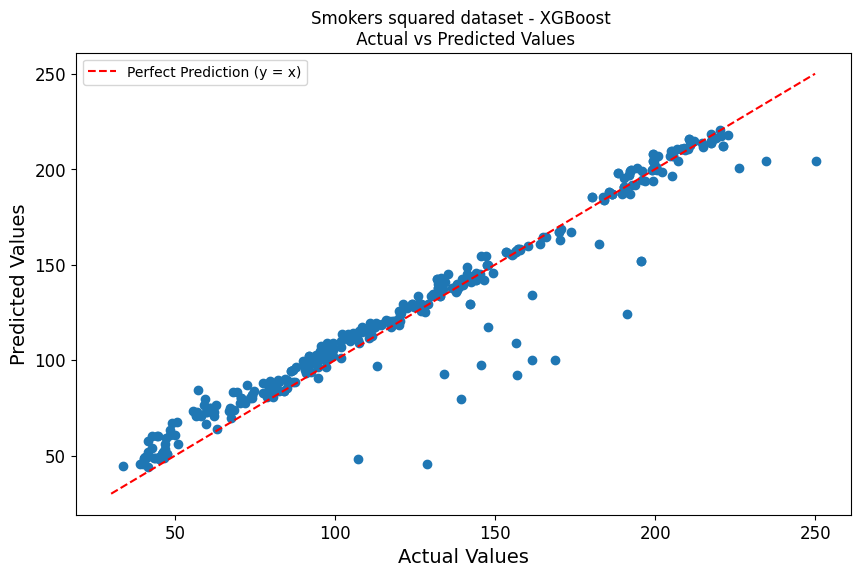

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(30, 250, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers squared dataset - XGBoost \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [171]:
param_grid = {
    'max_depth': [None, 3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 3}


In [172]:
best_xgb = grid_search.best_estimator_
y_predictions = best_xgb.predict(X_validation)
mse = root_mean_squared_error(y_validation, y_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 3.671273459157866
MAE: 7.575975422656905


Also here when we use the squared charges on the oversampled smoker dataset, the XGBoost performs the best. 

In [173]:
joblib.dump(best_xgb, 'data/models/best_model_smokers_squared.pkl')

['data/models/best_model_smokers_squared.pkl']

# **Conclusion**